<a href="https://colab.research.google.com/github/carlosfg97/WeatherCNN_WarutNet/blob/main/WarutNet_Weather_Conv_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CONV. NEURAL NET ( 2d convolutions example )**

## *Warut-Net* , 2021 

[For a video walkthrough go here](https://youtu.be/Vy6Gxttl-f8)

## Connections and Imports

In [ ]:
# Connection to Google Drive to retrieve Files
from google.colab import drive
drive.mount('/content/gdrive')
fname =  '/content/gdrive/My Drive/WarutNet/weatherHistory_shortv.csv'

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import random
import numpy as np
from datetime import timedelta

pd.set_option('display.max_rows', 100)

## Data Preprocessing

In [ ]:
# read dataset
df = pd.read_csv(fname, parse_dates=True, infer_datetime_format = True)

print(f'Dataset has {df.shape[0]} rows and  {df.shape[1]} columns. ')

Dataset has 41815 rows and  12 columns. 


In [ ]:
# datetime columns formatting and some range calibrations
df['Pressure'] = df['Pressure (millibars)']/100 # make numbers smaller
df['DATETIME'] = pd.to_datetime(df['Formatted Date'].apply(lambda x: x[:-10]))
df['DATE'] = df.DATETIME.dt.date
df['HOUR'] = df.DATETIME.dt.hour
df = df.drop(columns = ['Pressure (millibars)', 'Formatted Date'])

df = df.rename(columns = {'Precip Type': 'Ptype', 'Daily Summary':'SUMMARY'})
df1 = pd.get_dummies(df , columns = ['Summary','Ptype'])


In [ ]:
#df_summaries = df[df.HOUR == 1].SUMMARY.value_counts()
#df_summaries.to_csv('/content/gdrive/My Drive/insy 662 project 2/Code/summaries____.csv')

# we are going to use a remapping of weather summaries to have less classes to predict (generalizing)
df_map = pd.read_csv('/content/gdrive/My Drive/WarutNet/summaries.csv', sep=';')
print(df_map['New Summary'].drop_duplicates().to_list())

# Old summary (~160 labels ) ---> New Summary (6 labels)
df2 = df1.merge(df_map[['Old Summary ', 'New Summary']], left_on='SUMMARY', right_on='Old Summary ')
df2 = df2.drop( labels = ['Old Summary ', 'SUMMARY'], axis=1 ,  errors='ignore')
df2 = df2.rename( {'New Summary': 'SUMMARY'},   axis=1     )


['Breezy', 'Clear', 'Foggy', 'Mostly Cloudy', 'Overcast', 'Partly Cloudy']


In [ ]:
df1 = df2.copy()
df1['MONTH'] = df.DATETIME.dt.month

# we create a season column. Not exact formula but simple to implement
df1['SEASON'] = df1.DATETIME.dt.month%12 // 3 + 1

In [ ]:
feats = ['Temperature (C)', 'Apparent Temperature (C)', 'Humidity',
       'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Loud Cover', 'Pressure','MONTH', 'SEASON','Summary_Breezy',
       'Summary_Breezy and Foggy', 'Summary_Breezy and Mostly Cloudy',
       'Summary_Breezy and Overcast', 'Summary_Breezy and Partly Cloudy',
       'Summary_Clear', 'Summary_Dangerously Windy and Partly Cloudy',
       'Summary_Dry', 'Summary_Dry and Partly Cloudy', 'Summary_Foggy',
       'Summary_Humid and Mostly Cloudy', 'Summary_Humid and Overcast',
       'Summary_Humid and Partly Cloudy', 'Summary_Mostly Cloudy',
       'Summary_Overcast', 'Summary_Partly Cloudy', 'Summary_Windy',
       'Summary_Windy and Foggy', 'Summary_Windy and Mostly Cloudy',
       'Summary_Windy and Overcast', 'Summary_Windy and Partly Cloudy',
       'Ptype_rain', 'Ptype_snow']

Y_VAR = ['SUMMARY']

### Iterating through dataset and pivoting each panel data point

The next loop is **crucial** for the program. We iterate through all the
existing dates and filters the dataset for only that date (so we are going 
to have mini datasets of 24 rows (1 weather report per hour). We have to 
"transform" the dataset so we can keep the hours as rows and the weather
information as columns. We use pandas's pivot_table to efficiently achieve this. By the end of the loop, we will have an X vector composed of matrices that will be our "panel data points", so each data point is not a row like in traditional ML, but actually rows and columns.

![](https://drive.google.com/uc?export=view&id=1OLTvjaBCQLLFOc3B9HjVrEkAD30d0LfY)

In [ ]:
Xr = []
X_date = []
Yr =[] # next day summary 

# our Y variable is the WEATHER SUMMARY of the next day. 
# So we will try to predict that Y variable with panel data from the current day 

for date in df1.DATE.drop_duplicates():
  # X MATRIX 
  single_day = df1[df1.DATE == date] #our data point
  pivot_table = single_day.pivot_table( index= 'HOUR' ,values =feats, aggfunc='mean' ) # this line of code simplifies the program a lot!
  pivot_table = pivot_table[feats].values

  if pivot_table.shape == (24,33):
    # Y TARGET
    if len(df1.loc[df1.DATE == date + timedelta( days = 1), 'SUMMARY'].to_list()) >0 : 
      Xr.append(pivot_table)
      X_date.append(date)
      y_date = df1.loc[df1.DATE == date + timedelta( days = 1), 'SUMMARY'].to_list()[0]
      Yr.append(y_date)
  else:
    pass # we only want to append days which we have complete data to avoid errors in the CNN later

### Data Augmmentation

In Deep Learning, it is very important to have large datasets. So we perform some data augmentation to have more rows of examples. The objective is to take the dataset to a size of 100K rows (which is actually still considered a small sample for a network to work). We achieve these my randomly selecting rows from the matrix and appending them to the end of the list (we do this 100K times).

This works in this specific use case because we can assume that if we were to record an additional day of summer, for example, it would have very similar weather than a summer day of any other year. So it is "allowed" that we duplicate the data this way. For other use cases this could not be the case (i.e. churn modelling)

In [ ]:

for t in range(100000 - len(Xr)):
  i = random.randint(1, len(Xr))-1
  Xr.append(Xr[i])
  Yr.append(Yr[i])
  X_date.append(X_date[i])

print(len(Xr)) # we can see the X vector now has 100K rows!

100000


In [ ]:
from sklearn.preprocessing import Normalizer,StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder(  )
Y = le.fit_transform(Yr)



### Panel Datapoint Visualization

Since the CNN will process a bidimensional array, we can imagine that array as an image, where each value of the matrix is a pixel of the image. This helps to link the CNN to their more common application which is computer vision. In this use case specifically, we are processing structured data (not images) but just for the sake of materializing the preprocessing, lets plot it to see how it looks


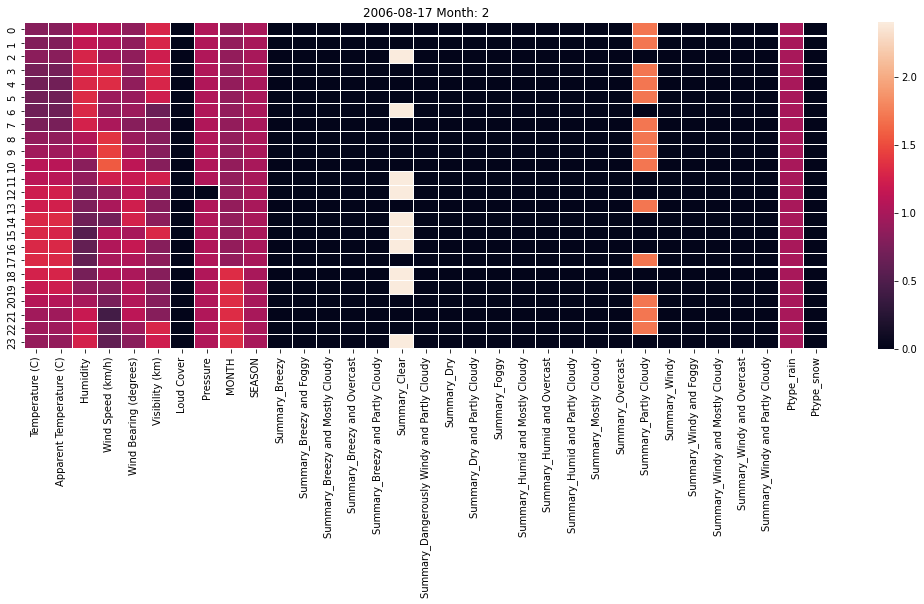

In [ ]:
i = random.randint(1,len(Xr))
fig, ax = plt.subplots(figsize=(18,6)) 

month = str(X_date[1].month%12 // 3 + 1)

pix = Xr[i]
pix_norm= np.divide(  pix, pix.mean(axis=0)+0.0001) # normalize for the picture to look good, but not necessary for the CNN

sns.heatmap( pix_norm, linewidths=.05, ax=ax,
           xticklabels = feats,
            ).set_title(str(X_date[i]) + ' Month: '   + month )

plt.show()


## Modelling

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
# we make sure we have the GPU turned on, which makes the training EXPONENTIALLY FASTER (2 minutes vs 30 minutes non-GPU)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name)) 

Num GPUs Available:  1
Found GPU at: /device:GPU:0


In [ ]:
X = np.array(Xr)
Y = np.array(Y)
print(len(X), len(Y))
X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size=0.1, random_state=42)

100000 100000


### WARUT-NET. Simple Convolutional 2D Network

2 conv layers with Batch Norm and ReLU activations. Max pool Layers.
Finally a flatten curve and a Fully Connected layer with 6 ouput neurons for 6-class prediction. No dropout because it worsened the results. The network generalizes well on testing data even without dropout layers

![](https://drive.google.com/uc?export=view&id=193FxqI_G9-EIgxZoipfUtWVXmE7-4lfP)





In [ ]:
inputs = keras.Input(shape=(24,33,1)) # days in the index and features in the rows

x = layers.Conv2D( filters=64, kernel_size=(2,2), strides=1 , 
                    name = 'conv1')(inputs)
x = layers.BatchNormalization()(x) 
x = layers.ReLU()(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=1, name='max1')(x)

x = layers.Conv2D(filters=128, kernel_size=(2,2), strides=2, 
                    name = 'conv2', padding = 'same' )(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=1, name='max2')(x)

x = layers.Flatten()(x)

outputs = layers.Dense(6,activation=tf.nn.softmax, name = 'soft2')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='weather')

# Train with Adam optimizer (best optimization method currently)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# We tested a lot with different kernel sizes, strides, number of filters, etc
# but the real difference was when we augmented data. This has way more impact 
# than any architecture adjustment we could make



In [ ]:
print(model.summary())

Model: "weather"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 24, 33, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 23, 32, 64)        320       
                                                                 
 batch_normalization_4 (Batc  (None, 23, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 re_lu_4 (ReLU)              (None, 23, 32, 64)        0         
                                                                 
 max1 (MaxPooling2D)         (None, 22, 31, 64)        0         
                                                                 
 conv2 (Conv2D)              (None, 11, 16, 128)       32896     
                                                           

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 500,    
                    epochs=8, verbose= 1 ) 

# network will go through dataset 8 times, so 100,000*8 epochs = 800,000 data points to train on
# network adjusts weights according to errors every 500 data points
# training this in a non-gpu machine would take at least 30 minutes! Google Collab <3

Epoch 1/8
180/180 [==============================] - 13s 67ms/step - loss: 1.2374 - accuracy: 0.5768
Epoch 2/8
180/180 [==============================] - 12s 66ms/step - loss: 0.7036 - accuracy: 0.7236
Epoch 3/8
180/180 [==============================] - 12s 67ms/step - loss: 0.5658 - accuracy: 0.7835
Epoch 4/8
180/180 [==============================] - 12s 67ms/step - loss: 0.4754 - accuracy: 0.8194
Epoch 5/8
180/180 [==============================] - 12s 67ms/step - loss: 0.3762 - accuracy: 0.8645
Epoch 6/8
180/180 [==============================] - 12s 67ms/step - loss: 0.3164 - accuracy: 0.8890
Epoch 7/8
180/180 [==============================] - 12s 67ms/step - loss: 0.2472 - accuracy: 0.9225
Epoch 8/8
180/180 [==============================] - 12s 67ms/step - loss: 0.1964 - accuracy: 0.9441


In [ ]:
y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=-1)

print(accuracy_score(y_test,y_pred))


# train accuracy and test accuracy is similar ==> No overfitting! :-)

0.9463


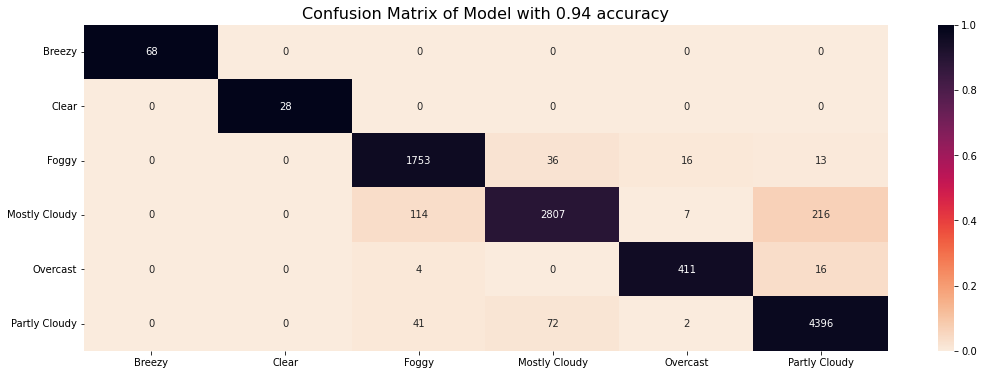

In [ ]:
# save results into dataset for further analysis
results = pd.DataFrame( data = [y_test,y_pred]).T
mapping = dict(zip(le.classes_, range(len(le.classes_))))
acc = accuracy_score(y_test,y_pred)

fig, ax = plt.subplots(figsize=(18,6)) 

sns.heatmap(confusion_matrix(y_test,y_pred, normalize='true'),
            robust=True,
            cmap = sns.cm.rocket_r,
            xticklabels = list(mapping.keys()) , 
            yticklabels = list(mapping.keys()),
            annot= confusion_matrix(y_test,y_pred), fmt='g').set_title(f'Confusion Matrix of Model with {str(acc)[:4]} accuracy',  fontsize=16)

plt.show()
